In [1]:
# install all dependencies

!pip install scikit-image # for skimage.measure
!pip install pymunk # for basic particle simulation utility (collision detection, update the particle state based on position and velocity)
!pip install numpy # for arrays and useful functions
!pip install pygame # for showing the simulation visually
!pip install matplotlib # for plotting

In [2]:
import pygame as pg
import pymunk # simulates in C -> fast 
import numpy as np
import skimage.measure as measure # for 2d max pooling (pip install scikit-image)
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
import random
import os

from objects import Person, Wall, Train
from simulator import CovidSim
from pathfinding import Node, Queue, Pathfinder

pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# setup the simulator
sim = CovidSim(
    n_people=500, 
    infection_prob=0.3, 
    draw_dots_for_debugging=False,
    FPS=60)

# TODO: put list of real target nodes into pf by design
pf = Pathfinder(sim, use_precomputed_heatmaps=True)

world_array shape: (800, 800)
using precomputed heatmaps with shape (3, 800, 800)


In [4]:
# hyperparameters
max_timestep = 2000
start_seed = 0
n_runs = 3
n_variance_bars = 5

for run_index in range(n_runs):
    print(f'starting run... [{run_index+1}/{n_runs}]')
    healthy_counts, infected_counts = sim.run(seed=start_seed+run_index, speedup_factor=1, max_timestep=max_timestep, return_data=True)

    if run_index == 0:
        # create lists with datapoints from multiple runs
        healthy_counts_data = [[] for i in range(len(healthy_counts))]
        infected_counts_data = [[] for i in range(len(infected_counts))]

    for i in range(len(healthy_counts)):
        healthy_counts_data[i].append(healthy_counts[i]) # healthy_counts[i * int(len(healthy_counts)/n_variance_bars)]
        infected_counts_data[i].append(infected_counts[i])

timesteps = [t for t in range(0, len(healthy_counts))]
healthy_counts_avg = [sum(datapoints)/len(datapoints) for datapoints in healthy_counts_data]
infected_counts_avg = [sum(datapoints)/len(datapoints) for datapoints in infected_counts_data]

starting run... [0/3]
starting run... [1/3]
starting run... [2/3]


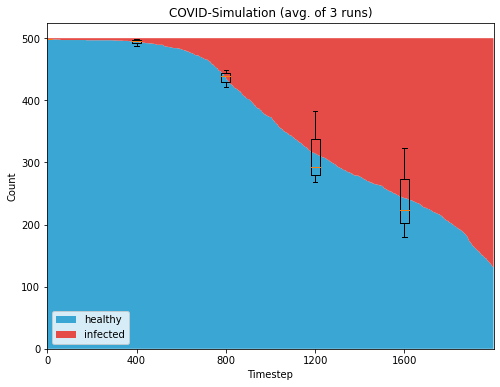

In [12]:
plt.figure(figsize=(8,6))
plt.stackplot(timesteps, healthy_counts_avg, infected_counts_avg, labels=['healthy', 'infected'], colors=['#39a6d4', '#e64c47']) # blue-grey-red

# if we used multiple runs, draw bars to show the variance between the runs
if n_runs > 1:
    plt.boxplot([healthy_counts_data[i*int(len(timesteps)/n_variance_bars)] for i in range(n_variance_bars)], 
    positions=[i*int(len(timesteps)/n_variance_bars) for i in range(n_variance_bars)], widths=int(len(timesteps)/50))

plt.title(f'COVID-Simulation (avg. of {n_runs} runs)')
plt.legend(loc='lower left', ncol=1)
plt.xlabel('Timestep')
plt.ylabel('Count')
plt.xlim(0, len(timesteps))
plt.show()